# First Model for the Prediction of Wakeup Events

In [2]:
# Import needed libraries and packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

import random

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

RSEED=42


### Getting the Data into Dataframe

In [3]:
# Define the directory containing the files
data_directory = 'data/file_per_night'

# Get a list of all file paths in the directory
file_paths = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, file))]

# Assuming each file is in a common format like CSV, you can use pd.read_csv
# Modify the read function according to your file format (e.g., pd.read_excel, pd.read_json, etc.)
dataframes = [pd.read_parquet(file) for file in file_paths]

# Concatenate all dataframes into a single dataframe
full_dataframe = pd.concat(dataframes, ignore_index=True)


To have only two classes, we set the event 'onset' to 'awake' and 'wakeup' to 'sleep'

In [4]:
full_dataframe['event'].unique()

array(['awake', 'onset', 'sleep', 'wakeup'], dtype=object)

In [5]:
for i in full_dataframe.index:
    if full_dataframe['event'][i] == 'onset':
        full_dataframe['event'][i] = 'awake'
    elif full_dataframe['event'][i] == 'wakeup':
        full_dataframe['event'][i] = 'sleep'
    else:
        continue

### Remove Nas

In [6]:
full_dataframe.isna().sum()

anglez            660
enmo              660
step              660
anglez_std        660
enmo_std          660
series_id         660
night         9097577
event               0
dtype: int64

In [7]:
# remove Nas
full_dataframe.drop('night', axis = 1, inplace =True)
full_dataframe.dropna(inplace=True)

In [8]:
full_dataframe.isna().sum()

anglez        0
enmo          0
step          0
anglez_std    0
enmo_std      0
series_id     0
event         0
dtype: int64

### Train / Test Split

Next, we perform the regular train-test-split, training and evaluation of the model as usual:

In [9]:
# Split the data into train and test sets with stratification
train_data, test_data = train_test_split(full_dataframe, test_size=0.25, stratify=full_dataframe['event'], random_state=RSEED)
# Now train_data and test_data contain your training and testing sets, respectively
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

Safe the train and test sets for later:

In [10]:
train_data.to_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data.to_parquet(os.path.join(data_directory, "test_data.parquet"))

In [11]:
# use this to read the train and test set, if they were already created
train_data = pd.read_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data = pd.read_parquet(os.path.join(data_directory, "test_data.parquet"))

In [12]:
train_data.head()

,anglez,enmo,step,anglez_std,enmo_std,series_id,event
0,18.020884,0.000000,94349.5,0.072287,0.000000,8a306e0890c0,sleep
1,55.877499,0.000000,133529.5,0.000000,0.000000,29c75c018220,sleep
2,38.646690,0.021192,216173.5,1.014712,0.000211,e2b60820c325,sleep
3,81.904381,0.000000,355817.5,0.036335,0.000000,e34b496b84ce,sleep
4,-73.088699,0.004400,336773.5,0.000000,0.000000,eec197a4bdca,sleep


## Setting up and training of the model

Model type: Decision Tree

In [13]:
# Extract features and target variable from the data
X_train = train_data.drop(['event', 'series_id', 'step'], axis=1).reset_index(drop=True)
y_train = train_data['event'].reset_index(drop=True)

X_test = test_data.drop(['event', "series_id", "step"], axis=1).reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

In [14]:
# Oversampling (because we have more sleep than awake)
# Apply SMOTE
smote = SMOTE(random_state=RSEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train= X_train_smote
y_train = y_train_smote

NameError: name 'train_data' is not defined

In [15]:
# Preprossessing of features
scaler = MinMaxScaler()

# Scaling of features
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[7.71873517e-01, 0.00000000e+00, 6.12728032e-04, 0.00000000e+00],
       [1.06247481e-01, 0.00000000e+00, 4.37371848e-04, 0.00000000e+00],
       [1.30967864e-01, 1.58904597e-03, 2.01535116e-03, 7.25683049e-05],
       ...,
       [4.52727446e-01, 2.31934135e-03, 1.06380832e-03, 6.05357975e-05],
       [1.61675019e-01, 3.75614334e-03, 3.26611072e-03, 1.19605515e-04],
       [2.06969748e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [16]:
# Initialize the Classifier
model = DecisionTreeClassifier(random_state=RSEED, max_depth=10)

In [17]:
# Train the model on the training data
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [18]:
# Make predictions on the test data
y_pred = model.predict(X_test)

Evaluation of the model performance:

In [19]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 88.36%
Precision on test data: 88.92%
Recall on test data: 88.36%
F1 Score on test data: 88.51%


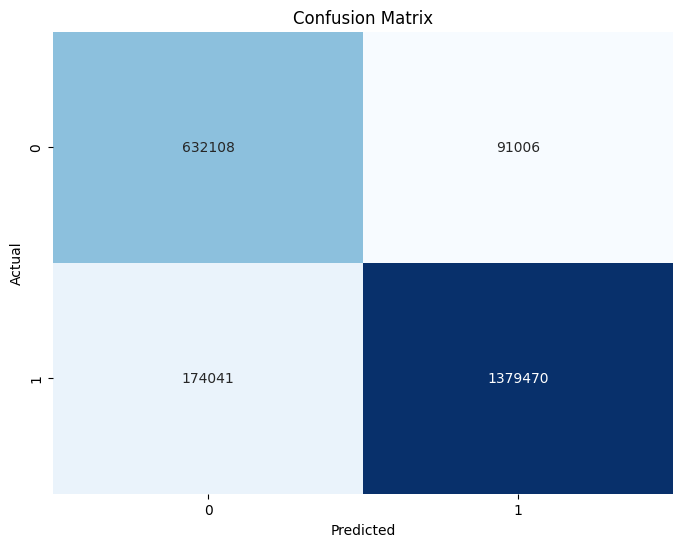

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Plot the decision tree model:

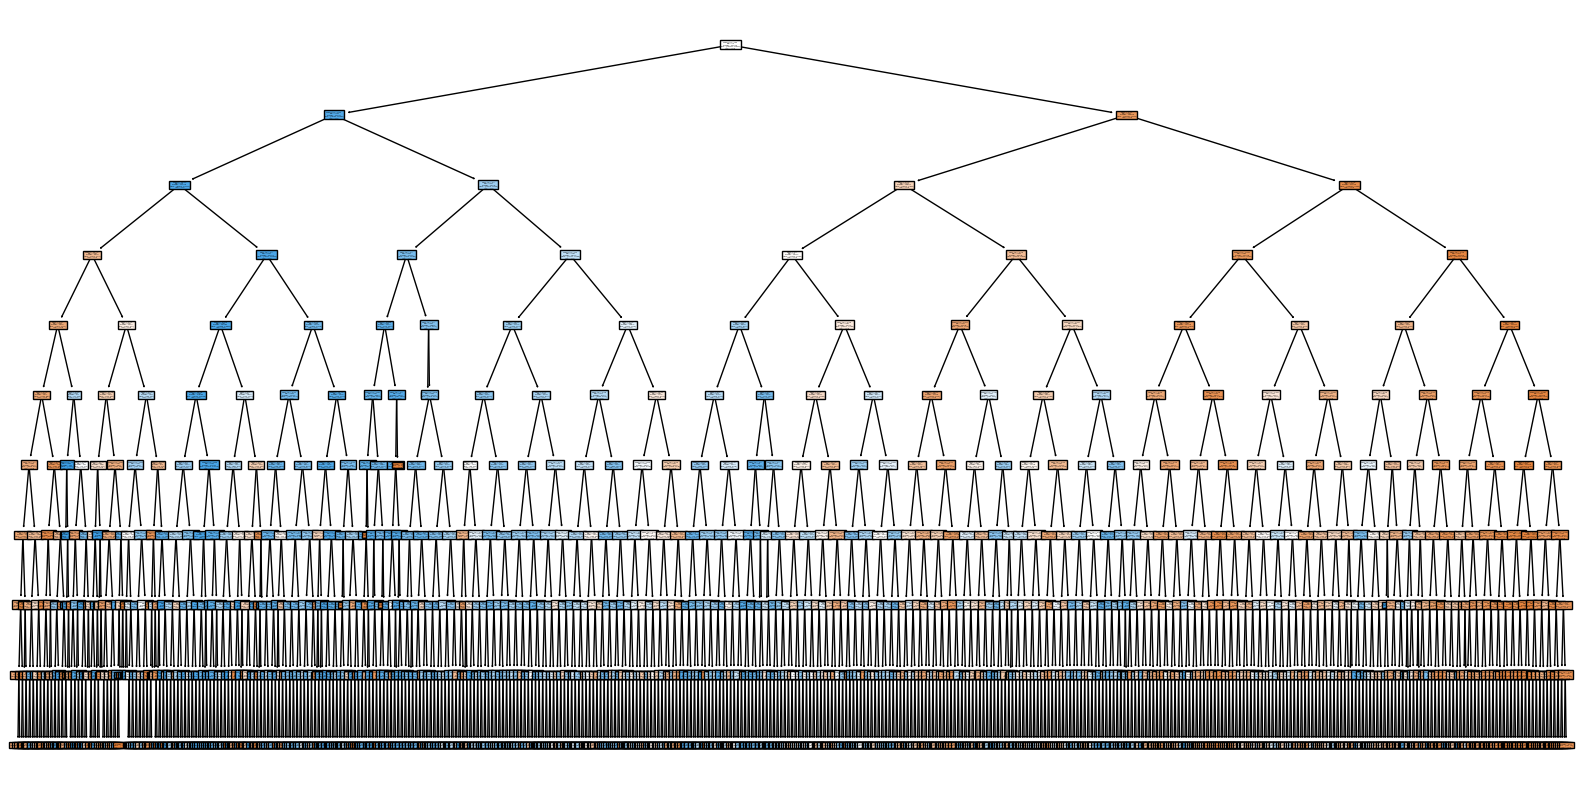

In [21]:
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=model.classes_)
plt.show()

## Grid Search

To find a better performing model, we perform a grid search testing different parameters:

In [22]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree Classifier
modelCV = DecisionTreeClassifier(random_state = RSEED)

In [23]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(modelCV, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 20]},
             scoring='accuracy')

In [25]:
# Print the best parameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Accuracy: 0.9001684577122534


### Validation of best model

In [26]:
best_model = DecisionTreeClassifier(criterion= 'gini', max_depth= 20, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 5)


In [27]:
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, max_features='sqrt', min_samples_split=5)

In [28]:
y_pred_best = best_model.predict(X_test)

In [29]:
accuracy = accuracy_score(list(y_test), list(y_pred_best))
precision = precision_score(list(y_test), list(y_pred_best), average='weighted')
recall = recall_score(list(y_test), list(y_pred_best), average='weighted')
f1 = f1_score(list(y_test), list(y_pred_best), average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 90.09%
Precision on test data: 90.46%
Recall on test data: 90.09%
F1 Score on test data: 90.20%


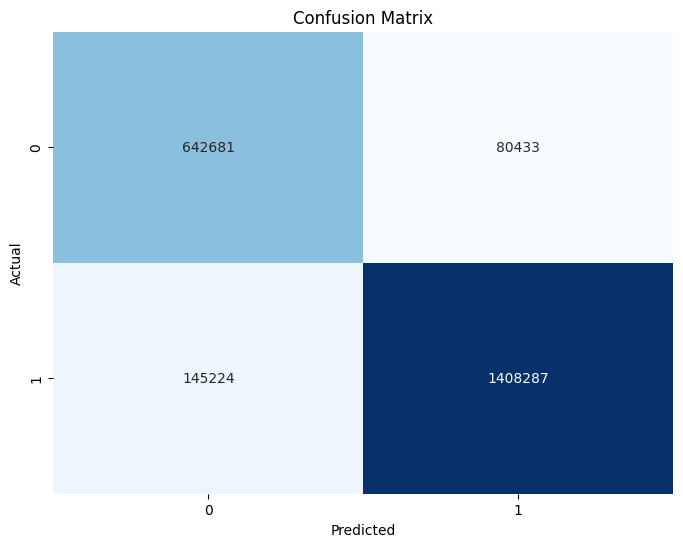

In [30]:
# Compute confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred_best))

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()